In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import copy

%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params
plot_utils.set_all_font_sizes(16)
from utils import roi_utils, default_paths, stats_utils

In [2]:
# Load results of the fitting procedure

subject = 1
volume_space=True
feature_type_list_long = ['semantic_discrim_raw_val', 'gabor_solo_ridge_12ori_8sf',\
                 'texture_pyramid_ridge_4ori_4sf_pca_HL','sketch_tokens',\
                 'alexnet_best_layer_pca', 'clip_RN50_best_layer_pca']
feature_type_list = ['raw','gabor',\
                 'texture_pyramid','sketch_tokens',\
                 'alexnet', 'clip']

nf = [0,0,0,0,0,0,0]

for fi, fitting_type in enumerate(feature_type_list_long):
    out= load_fits.load_fit_results(subject, fitting_type,n_from_end=nf[fi],verbose=True);

    if fi==0:
        n_voxels = out['sem_corr_each_axis'].shape[0]
        n_discrim_types = out['sem_discrim_each_axis'].shape[1]
        sem_corr = np.zeros((len(feature_type_list), n_discrim_types, n_voxels))
        sem_discrim = np.zeros((len(feature_type_list), n_discrim_types, n_voxels))
        clip_r2 = np.zeros((n_voxels,))
        discrim_type_list = out['discrim_type_list']
        
    sem_corr[fi,:,:] = copy.deepcopy(out['sem_corr_each_axis'].T)
    sem_discrim[fi,:,:] = copy.deepcopy(out['sem_discrim_each_axis'].T)
    
    if fi==0:
        n_samp = out['n_sem_samp_each_axis']
    else:
        try:
            n_samp2 = out['n_sem_samp_each_axis']
            assert(np.all(n_samp[~np.isnan(n_samp)]==n_samp2[~np.isnan(n_samp2)]))
        except:
            print('n_sem_samp field is missing')    
                
    # take out any pRFs/semantic axes where there were fewer than 10 val set trials
    # that had defined labels, because t-stats won't be very stable.
    for aa in range(n_discrim_types):

        min_samp = 10
        
        exclude_vox = np.any(n_samp[:,aa,:]<min_samp, axis=1)
#         print('excluding %d vox'%np.sum(exclude_vox))
        sem_corr[fi,aa,exclude_vox] = np.nan
        sem_discrim[fi,aa,exclude_vox] = np.nan
        
    if 'clip' in fitting_type:
        clip_r2 = out['val_r2'][:,0]

np.all(np.isnan(sem_discrim)==np.isnan(sem_corr))
sem_discrim[np.isinf(sem_discrim)] = np.nan

which_prf_grid=5
top_two_fn = os.path.join(default_paths.stim_labels_root, \
                           'Coco_supcat_top_two_prf_grid%d.npy'%(which_prf_grid))
top_two = np.load(top_two_fn, allow_pickle=True).item()
top_two['things_top_two']['animal']

roi_def = roi_utils.nsd_roi_def(subject, verbose=False)

loading from /user_data/mmhender/imStat/model_fits/S01/semantic_discrim_raw_val/Feb-21-2022_2343_12/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'debug', 'up_to_sess', 'single_sess', 'best_model_each_voxel', 'saved_prfs_fn', 'sem_discrim_each_axis', 'sem_corr_each_axis', 'discrim_type_list', 'n_sem_samp_each_axis'])
loading from /user_data/mmhender/imStat/model_fits/S01/gabor_solo_ridge_12ori_8sf/Feb-05-2022_2056_56/all_fit_params.npy

dict_keys(['subject', 'volume_space', 'fitting_types', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'which_prf_grid', 'models', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'single_sess', 'shuff_rnd_seed', 'use_precomputed_prfs', 'saved_prfs_fn', 'best_laye

In [3]:
sem_discrim.shape

(6, 55, 19738)

In [5]:
# make some groups (averaging over all superord or basic level discrims)

inds2group = [[0], [1], [2], [3], np.arange(4,16), np.arange(27,43), np.arange(16,27), np.arange(43,55)]
group_names = [discrim_type_list[ii] for ii in [0,1,2,3]] + \
                ['things-superord','stuff-superord' ,'things-basic', 'stuff-basic']

n_vox = sem_discrim.shape[2]
sem_discrim_grouped = np.zeros((len(feature_type_list), len(inds2group), n_vox))
for gg, inds in enumerate(inds2group):
    sem_discrim_grouped[:,gg,:] = np.nanmean(np.abs(sem_discrim[:,inds,:]), axis=1)
    print(group_names[gg])
    print(np.array(discrim_type_list)[inds])

indoor_outdoor
['indoor_outdoor']
natural_humanmade
['natural_humanmade']
animacy
['animacy']
real_world_size
['real_world_size']
things-superord
['accessory' 'animal' 'appliance' 'electronic' 'food' 'furniture' 'indoor'
 'kitchen' 'outdoor' 'person' 'sports' 'vehicle']
stuff-superord
['building' 'ceiling' 'floor' 'food-stuff' 'furniture-stuff' 'ground'
 'other' 'plant' 'raw-material' 'sky' 'solid' 'structural' 'textile'
 'wall' 'water' 'window']
things-basic
['within_accessory' 'within_animal' 'within_appliance' 'within_electronic'
 'within_food' 'within_furniture' 'within_indoor' 'within_kitchen'
 'within_outdoor' 'within_sports' 'within_vehicle']
stuff-basic
['within_building' 'within_floor' 'within_food-stuff'
 'within_furniture-stuff' 'within_ground' 'within_plant'
 'within_raw-material' 'within_solid' 'within_structural' 'within_textile'
 'within_wall' 'within_water']


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


In [6]:
sem_discrim_grouped.shape

(6, 8, 19738)

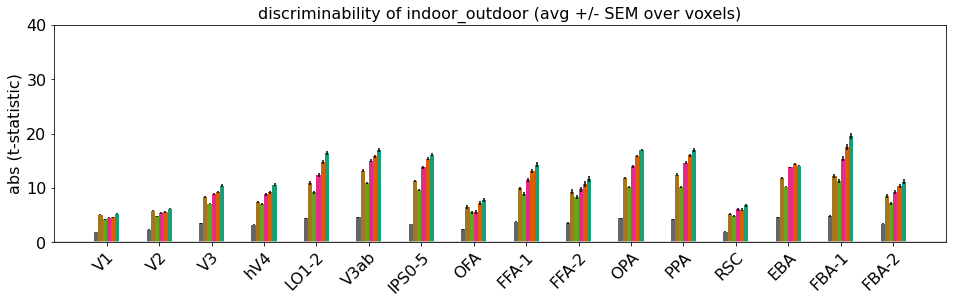

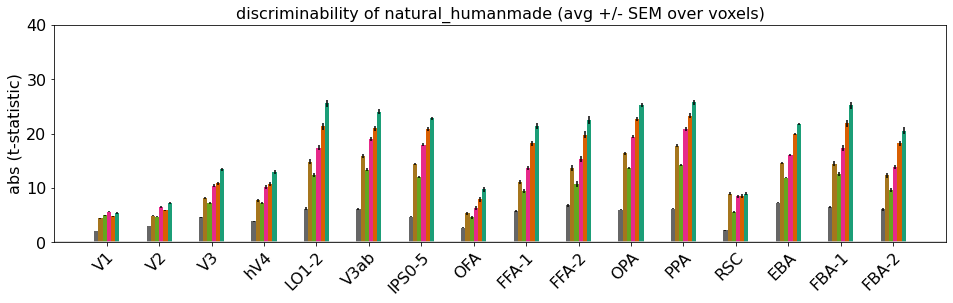

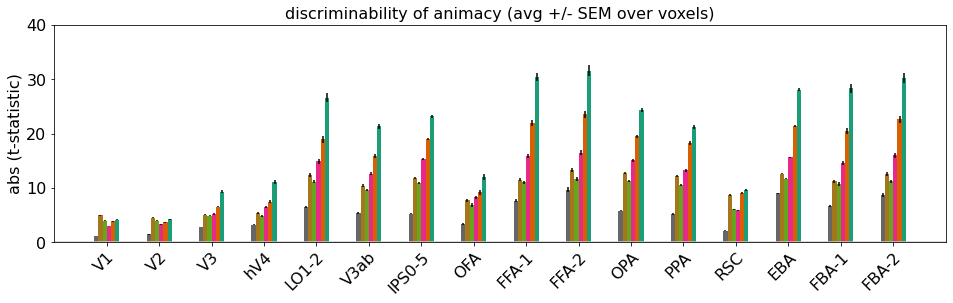

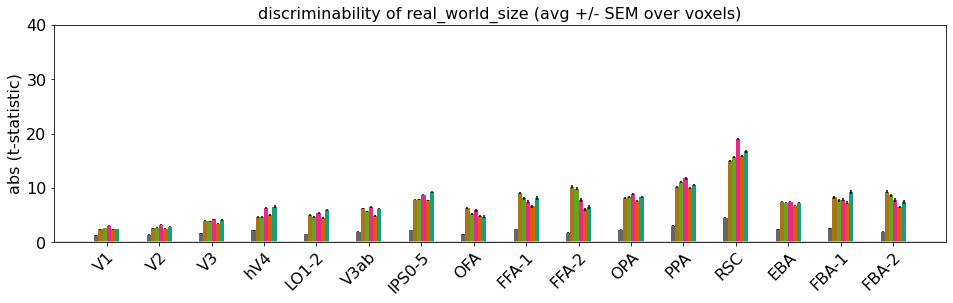

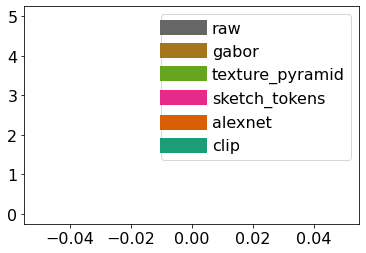

In [8]:
# plot abs tstat for higher-level categories

roi_names =roi_def.roi_names
skip_inds = [4,5,7,10,11,15,16,23]
areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]

feature_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(feature_type_list))))
bar_jitters = np.linspace(-0.25, 0.25,len(feature_type_list))
bar_width = np.diff(bar_jitters[0:2])[0]

dd2plot = [0,1,2,3]

vox2use = out['val_r2'][:,0]>0.01

for dd in dd2plot:
    
    discrim_type = discrim_type_list[dd]
    
    mean_vals = np.zeros((len(areas2plot),len(feature_type_list)))
    sem_vals = np.zeros((len(areas2plot),len(feature_type_list)))
    
    for ri, rr in enumerate(areas2plot):
        
        inds_this_roi = roi_def.get_indices(rr) & vox2use
        vals_this_roi = np.abs(sem_discrim[:,dd,inds_this_roi])
       
        mean_vals[ri,:] = np.mean(vals_this_roi, axis=1)
        sem_vals[ri,:] = np.std(vals_this_roi, axis=1)/np.sqrt(np.sum(inds_this_roi))
   
    legend_separate = (dd==len(dd2plot)-1)
    title = 'discriminability of %s (avg +/- SEM over voxels)'%(discrim_type)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=feature_colors, space=0.3, \
                xticklabels=np.array(roi_names)[areas2plot], ylabel='abs (t-statistic)', \
                ylim=[0, 40], title=title, horizontal_line_pos=0,\
                legend_labels=feature_type_list, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

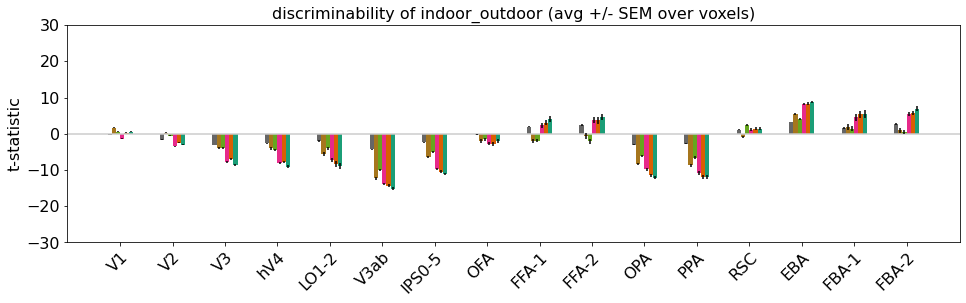

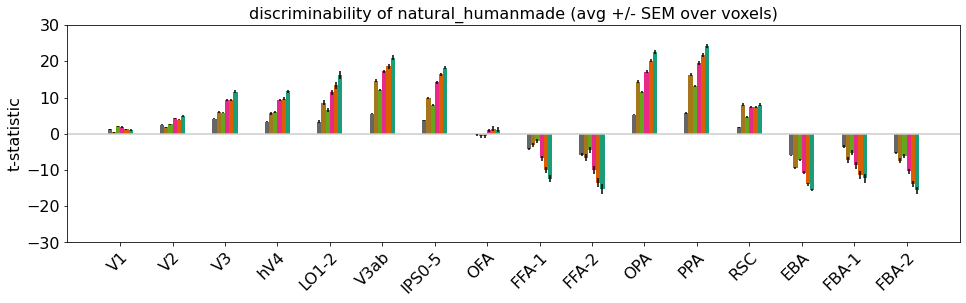

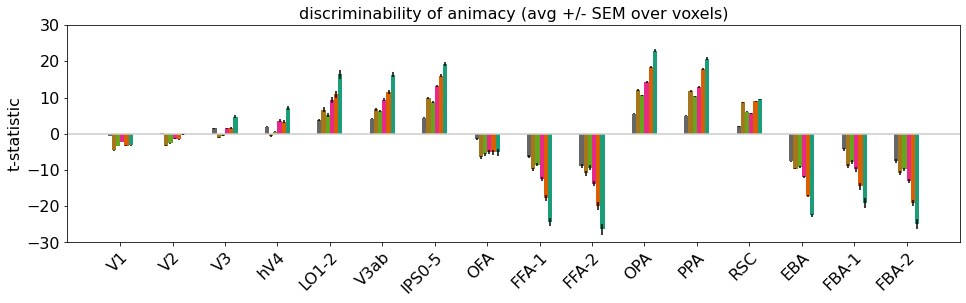

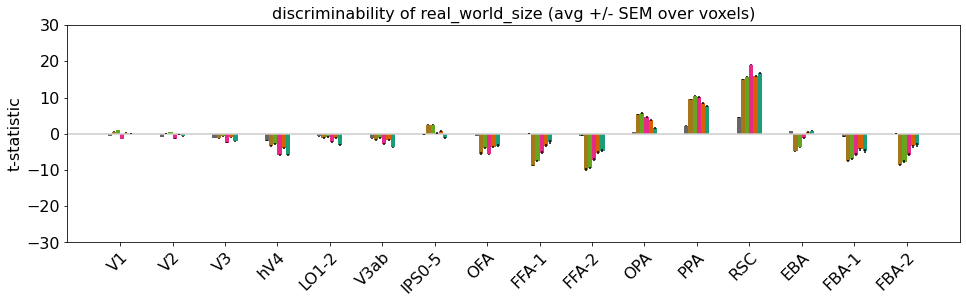

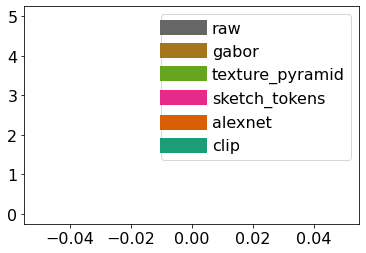

In [9]:
# plot signed tstat for higher-level categories

roi_names =roi_def.roi_names
skip_inds = [4,5,7,10,11,15,16,23]
areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]

feature_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(feature_type_list))))
bar_jitters = np.linspace(-0.25, 0.25,len(feature_type_list))
bar_width = np.diff(bar_jitters[0:2])[0]

dd2plot = [0,1,2,3]

vox2use = out['val_r2'][:,0]>0.01

for dd in dd2plot:
    
    discrim_type = discrim_type_list[dd]
    
    mean_vals = np.zeros((len(areas2plot),len(feature_type_list)))
    sem_vals = np.zeros((len(areas2plot),len(feature_type_list)))
    
    for ri, rr in enumerate(areas2plot):
        
        inds_this_roi = roi_def.get_indices(rr) & vox2use
        vals_this_roi = sem_discrim[:,dd,inds_this_roi]
       
        mean_vals[ri,:] = np.mean(vals_this_roi, axis=1)
        sem_vals[ri,:] = np.std(vals_this_roi, axis=1)/np.sqrt(np.sum(inds_this_roi))
   
    legend_separate = (dd==len(dd2plot)-1)
    title = 'discriminability of %s (avg +/- SEM over voxels)'%(discrim_type)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=feature_colors, space=0.3, \
                xticklabels=np.array(roi_names)[areas2plot], ylabel='t-statistic', \
                ylim=[-30,30], title=title, horizontal_line_pos=0,\
                legend_labels=feature_type_list, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))

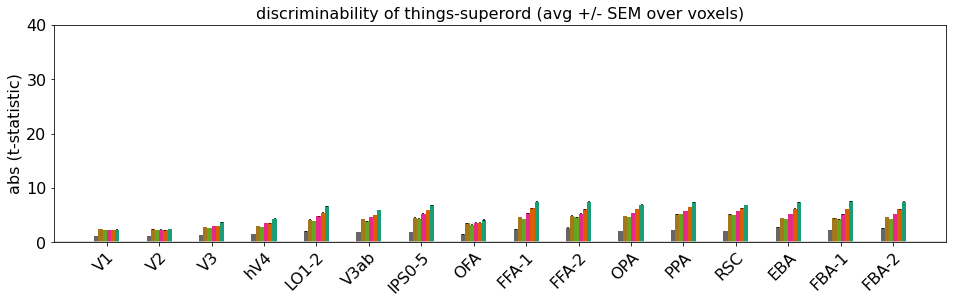

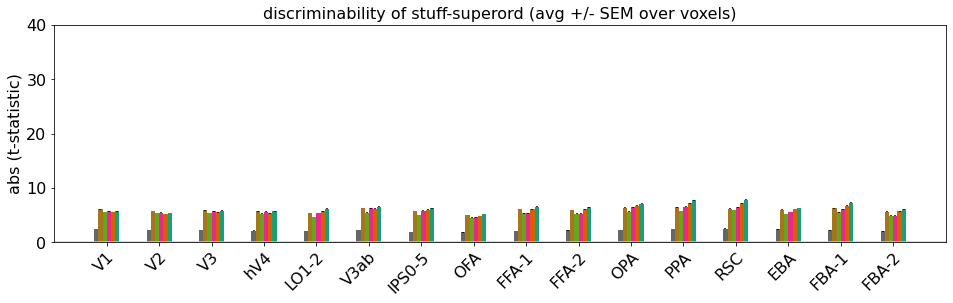

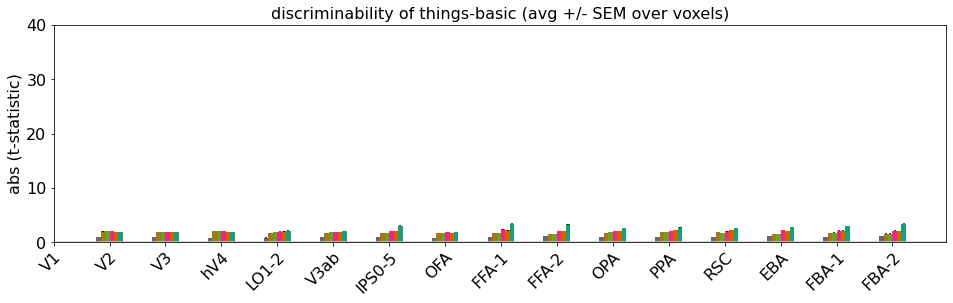

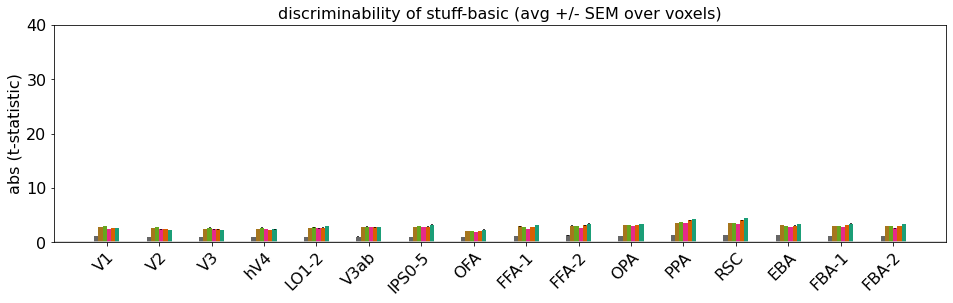

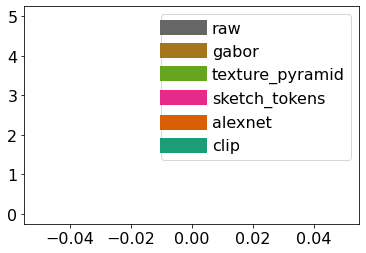

In [11]:
# plot discriminability for all the different levels of categorization

roi_names =roi_def.roi_names
skip_inds = [4,5,7,10,11,15,16,23]
areas2plot = np.arange(len(roi_names))
areas2plot = areas2plot[~np.isin(areas2plot, skip_inds)]

feature_colors = np.flipud(cm.Dark2(np.linspace(0,1,len(feature_type_list))))
bar_jitters = np.linspace(-0.25, 0.25,len(feature_type_list))
bar_width = np.diff(bar_jitters[0:2])[0]

dd2plot = [0,1,2,3,4,5,6,7]

vox2use = out['val_r2'][:,0]>0.01

for dd in dd2plot:
    
    if dd<4:
        continue
    
    discrim_type = group_names[dd]
    
    mean_vals = np.zeros((len(areas2plot),len(feature_type_list)))
    sem_vals = np.zeros((len(areas2plot),len(feature_type_list)))
    
    for ri, rr in enumerate(areas2plot):
        
        inds_this_roi = roi_def.get_indices(rr) & vox2use
        vals_this_roi = np.abs(sem_discrim_grouped[:,dd,inds_this_roi])
       
        mean_vals[ri,:] = np.mean(vals_this_roi, axis=1)
        sem_vals[ri,:] = np.std(vals_this_roi, axis=1)/np.sqrt(np.sum(inds_this_roi))
   
    legend_separate = (dd==len(dd2plot)-1)
    title = 'discriminability of %s (avg +/- SEM over voxels)'%(discrim_type)

    plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=feature_colors, space=0.3, \
                xticklabels=np.array(roi_names)[areas2plot], ylabel='abs (t-statistic)', \
                ylim=[0, 40], title=title, horizontal_line_pos=0,\
                legend_labels=feature_type_list, \
                legend_overlaid=False, legend_separate=legend_separate, \
                fig_size=(16,4))